<a href="https://colab.research.google.com/github/aishwarya-agrawal/twitter-analysis/blob/master/ULMFitontweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files 
uploaded = files.upload()


Saving Tweets.csv to Tweets.csv


In [0]:
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [0]:
df = pd.read_csv(io.StringIO(uploaded['Tweets.csv'].decode('utf-8')))

In [0]:
df['airline'].unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways', 'American'], dtype=object)

In [0]:
df.shape

(14640, 15)

In [0]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
train,test = train_test_split(df, test_size=0.33, random_state=42)

In [0]:
train,val = train_test_split(train, test_size=0.2, random_state=1)

In [0]:
def clean_ascii(text):
    # function to remove non-ASCII chars from data
    return ''.join(i for i in text if ord(i) < 128)



In [8]:
import torch
print("Cuda available" if torch.cuda.is_available() is True else "CPU")
print("PyTorch version: ", torch.__version__)

Cuda available
PyTorch version:  1.0.1.post2


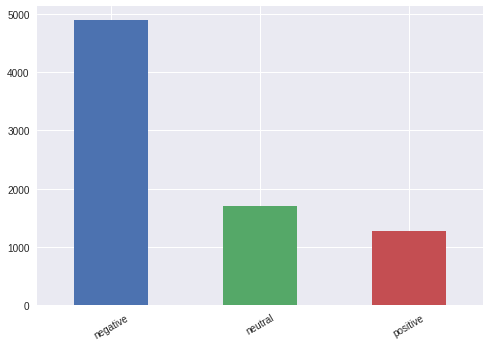

In [9]:
train['airline_sentiment'].value_counts().plot.bar(rot=30);

In [0]:
import re
def clean_atrate(text):
    # function to remove non-ASCII chars from data
    return re.sub(r'@[A-Za-z0-9]+','',text)

In [0]:
train['text'] = train['text'].apply(clean_ascii)
train['text'] = train['text'].apply(clean_atrate)

In [29]:
train['text'].head()

194                     Just DM'd. Same issue persisting.
2657     I sent a DM re an existing reservation but no...
2551     stellar customer service. You have earned my ...
6317     By the way the flight number was 1703, please...
7423     the fact that #ChrisHasMadeUsBLUSH isn't tren...
Name: text, dtype: object

In [30]:
train1 = pd.concat([train['airline_sentiment'], train['text']], axis=1)
train1.tail()

,airline_sentiment,text
5499,negative,is that the same reliable system couldn't fin...
10177,negative,my flight has been Cancelled Flightled. On h...
14599,negative,It's not the weather. It's also gross incomp...
6124,neutral,#DestinationDragons Any word on winners of co...
8201,neutral,flight 2302 from JFK to BUF.


In [0]:
val['text'] = val['text'].apply(clean_ascii)
val['text'] = val['text'].apply(clean_atrate)

In [0]:
!mkdir train

In [0]:
train1.to_csv('train/train.csv', index=False, header=False)

In [33]:
val1 = pd.concat([val['airline_sentiment'], val['text']], axis=1)
val1.tail()

,airline_sentiment,text
11582,negative,of course never again tho . Thanks for tweeti...
6535,negative,Yes but they couldn't explain the 2 hour and ...
5904,neutral,Do y'all know when the new routes from HOU to...
7897,negative,"It's not ideal, but it's okay. Better Late Fl..."
8561,neutral,Any EMS window seats on 1099 tomorrow?


In [0]:
val.to_csv('train/val.csv',index = False,header = False)

In [0]:
from pathlib import Path
path = Path('/content/train')

In [0]:
path_test = path/'train.csv'
path_val= path/'val.csv'

In [0]:
data_lm = TextLMDataBunch.from_csv('train/', 'train.csv', min_freq=1)

In [75]:
% cd ..

/content


In [0]:
# Save the language and classifier model data for re-use
data_lm.save()

In [80]:
data_lm.show_batch()

idx,text
0,"! xxmaj have a good xxmaj sunday . xxbos first time flying you all . do you have a different rate / policy for media xxmaj bags ? xxmaj thanks xxbos just added # passbook support to their ios application ! xxmaj finally , i get to add them to my collection . http : / / t.co / lednocdqee xxbos flying to xxmaj denver xxmaj march 1st and my"
1,and too many delays . xxbos darn ! i bought it on the wrong device ! xxmaj no way to switch i 'm sure ? xxbos your customer service is a disgrace . xxbos xxmaj how can i refer a friend for the xxmaj southwest xxmaj credit card for points ? xxbos can you guys help me please ? xxbos see you on board tomorrow xxbos no wifi on flight
2,"machines are broken , lines are out the door for self service , cust . xxmaj support , and bag check in . xxbos : xxmaj our fleet 's on fleek . http : / / t.co / dxn58rxdks see . xxbos i did but i got nothing from it . xxmaj just dissapointment =( xxbos & & if that was n't enough , your staff have been so rude"
3,"'ve lost my baggage . xxmaj no clean clothes . $ 337 flight . xxmaj thx ! xxbos yeah it happens . xxmaj the xxup phx airport has extra long waits all spring long . xxmaj something locals know but tourist do n't just xxup fyi xxbos xxmaj thank you . : xxmaj customer xxmaj relations will review your concerns and contact you back directly , xxmaj john . xxbos"
4,fail xxbos from a service rep but that has n't happened yet . i 'm honestly fed up and sick of this . xxmaj no notice when my flight got xxmaj cancelled xxmaj flighted xxbos xxmaj sending thanks to employee xxmaj freddie in xxup phl xxmaj admiral xxmaj club a xxmaj east for allowing me to give a day pass to my sibling stuck there today . xxbos xxmaj felt


In [0]:
learn = language_model_learner(data_lm,arch=AWD_LSTM, pretrained=True, drop_mult=0.1)

In [82]:
list(learn.model.children())

[AWD_LSTM(
   (encoder): Embedding(9317, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(9317, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1150, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1150, 1150, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1150, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=9317, bias=True)
   (output_dp): RNNDropout()
 )]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


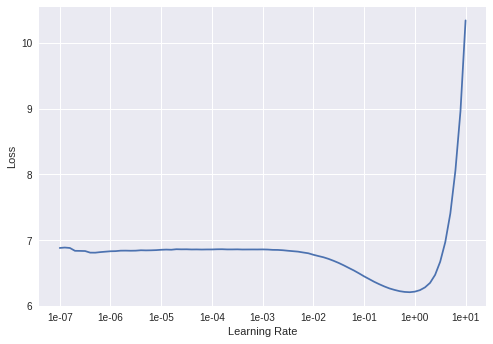

In [83]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [99]:


learn = language_model_learner(data_lm,arch =AWD_LSTM, pretrained=True, 
                               drop_mult=0.5)
learn.fit_one_cycle(cyc_len=1, max_lr=1e-1,moms=(0.8, 0.7))


epoch,train_loss,valid_loss,accuracy,time
0,5.405635,4.567328,0.217287,00:13


In [100]:
learn.unfreeze()
learn.fit_one_cycle(cyc_len=10, max_lr=1e-1, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.615128,4.341171,0.238517,00:16
1,4.501008,4.626703,0.205580,00:16
2,4.471383,4.611887,0.221801,00:16
3,4.385086,4.615117,0.223189,00:16
4,4.276680,4.622473,0.226711,00:16
5,4.119726,4.625857,0.230506,00:16
6,3.882688,4.685355,0.236359,00:16
7,3.566237,4.785425,0.237103,00:16
8,3.195343,4.931743,0.237971,00:16
9,2.876959,5.016921,0.237599,00:16


In [0]:
# Save the fine-tuned encoder
learn.save_encoder('ft_enc')

In [102]:
for item in train.airline.unique():
    print(item)

Virgin America
United
Southwest
Delta
US Airways
American


In [0]:
topic = "Delta"

In [0]:
# Get only those tweets that pertain to a single topic in the training data
train_topic = train1.loc[train['airline'] == topic]

In [0]:

train_topic.to_csv('train/train_topic.csv', index=False, header=False)

In [0]:
# Classifier model data
data_clas = TextClasDataBunch.from_csv('train/', 'train_topic.csv', vocab=data_lm.train_ds.vocab,
                                       min_freq=1, bs=32)
data_clas.save()


In [0]:
learn = text_classifier_learner(data_clas, drop_mult=0.5,arch =AWD_LSTM)
learn.load_encoder('ft_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


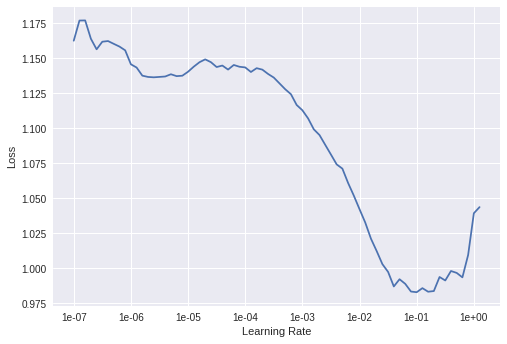

In [108]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [115]:
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.724387,0.743363,0.675214,00:01


In [117]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.648012,0.754465,0.705128,00:02


In [118]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.595674,0.747365,0.705128,00:03


In [119]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.607068,0.748527,0.696581,00:04
1,0.583354,0.757515,0.683761,00:04
2,0.585455,0.748293,0.705128,00:04
3,0.562472,0.757257,0.692308,00:04


In [120]:
# get predictions
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis=1)
pd.crosstab(predictions, targets)

col_0,0,1,2
row_0,,,
0,70,15,7
1,19,48,12
2,10,9,44


In [123]:
test.columns

Index(['airline_sentiment', 'airline_sentiment_confidence', 'negativereason',
       'negativereason_confidence', 'airline', 'airline_sentiment_gold',
       'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord',
       'tweet_created', 'tweet_location', 'user_timezone'],
      dtype='object')

In [124]:

test['text'] = test['text'].apply(clean_ascii)
test['text'] = test['text'].apply(clean_atrate)
test.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
4794,positive,1.0000,NaN,NaN,Southwest,NaN,JasmineDT,NaN,1,you're my early frontrunner for best airline!...,NaN,2015-02-22 21:30:54 -0800,Washington D.C.,Eastern Time (US & Canada)
10480,negative,1.0000,Cancelled Flight,1.0000,US Airways,NaN,ElizabethFrayer,NaN,0,how is it that my flt to EWR was Cancelled Fl...,NaN,2015-02-21 14:32:19 -0800,NaN,NaN
8067,negative,1.0000,Late Flight,0.6770,Delta,NaN,The_Radifier,NaN,0,what is going on with your BDL to DCA flights...,NaN,2015-02-20 09:05:13 -0800,"Arlington, VA",Atlantic Time (Canada)
8880,neutral,1.0000,NaN,NaN,Delta,NaN,rnlewisjr,NaN,0,"do they have to depart from Washington, D.C.??",NaN,2015-02-17 12:01:29 -0800,"iPhone: 60.495510,-151.064590",Alaska
8292,negative,0.6625,Customer Service Issue,0.3394,Delta,NaN,beantoon,NaN,0,I can probably find some of them. Are the tic...,NaN,2015-02-19 13:44:20 -0800,"Plymouth, MA",NaN


In [125]:
test_pred = test[['airline', 'text']]
test_pred = test_pred.loc[test_pred['airline'] == topic]
test_pred.tail()

,airline,text
7573,Delta,Thanks for the personalized customer service!...
8159,Delta,probably not anymore.
7456,Delta,wondering if it's possible for my colleague a...
8700,Delta,'s CEO Battles to Appease Passengers and Wall ...
7831,Delta,Kudos to JetBlue social media team for jumpin...


In [0]:
test_pred['airline_sentiment'] = test_pred['text'].apply(lambda row: str(learn.predict(row)[0]))

In [127]:
test_pred.head()

,airline,text,airline_sentiment
8067,Delta,what is going on with your BDL to DCA flights...,negative
8880,Delta,"do they have to depart from Washington, D.C.??",neutral
8292,Delta,I can probably find some of them. Are the tic...,neutral
7894,Delta,Thank you ! What about Paris ? Could we arran...,neutral
7458,Delta,now we dont have enough money for parking in ...,negative


In [129]:
!ls

bin   content  dev  home  lib32  media	opt   root  sbin  swift  tmp	usr
boot  datalab  etc  lib   lib64  mnt	proc  run   srv   sys	 tools	var


In [128]:
% cd ..

/


In [0]:
% mkdir test

In [131]:
% cd test

/test


In [0]:
% mkdir eval

In [133]:
% cd ..

/


In [0]:
test_pred.to_csv('test/eval/predicted.csv', index=True,
                 header=['airline', 'text', 'airline_sentiment'], index_label='ID')

In [135]:
%cd test


/test


In [136]:

%cd eval

/test/eval


In [0]:
file = pd.read_csv('predicted.csv')

In [138]:
!ls

predicted.csv


In [139]:
file.head()

,ID,airline,text,airline_sentiment
0,8067,Delta,what is going on with your BDL to DCA flights...,negative
1,8880,Delta,"do they have to depart from Washington, D.C.??",neutral
2,8292,Delta,I can probably find some of them. Are the tic...,neutral
3,7894,Delta,Thank you ! What about Paris ? Could we arran...,neutral
4,7458,Delta,now we dont have enough money for parking in ...,negative


In [140]:
test['airline_sentiment'][df['airline']=='Delta'].head()

8067    negative
8880     neutral
8292    negative
7894     neutral
7458    negative
Name: airline_sentiment, dtype: object

In [141]:
test1 = test[df['airline']=='Delta']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [142]:
test1.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
8067,negative,1.0000,Late Flight,0.6770,Delta,NaN,The_Radifier,NaN,0,what is going on with your BDL to DCA flights...,NaN,2015-02-20 09:05:13 -0800,"Arlington, VA",Atlantic Time (Canada)
8880,neutral,1.0000,NaN,NaN,Delta,NaN,rnlewisjr,NaN,0,"do they have to depart from Washington, D.C.??",NaN,2015-02-17 12:01:29 -0800,"iPhone: 60.495510,-151.064590",Alaska
8292,negative,0.6625,Customer Service Issue,0.3394,Delta,NaN,beantoon,NaN,0,I can probably find some of them. Are the tic...,NaN,2015-02-19 13:44:20 -0800,"Plymouth, MA",NaN
7894,neutral,1.0000,NaN,NaN,Delta,NaN,theycallme_HH,NaN,0,Thank you ! What about Paris ? Could we arran...,"[0.0, 0.0]",2015-02-21 02:10:01 -0800,Orleans/Tarpon Springs/London,Amsterdam
7458,negative,1.0000,Can't Tell,0.3516,Delta,NaN,emilybholan,NaN,0,now we dont have enough money for parking in ...,NaN,2015-02-22 11:58:29 -0800,N Y,NaN


In [143]:
file['airline_sentiment'].head()

0    negative
1     neutral
2     neutral
3     neutral
4    negative
Name: airline_sentiment, dtype: object

In [0]:
resultcomp = pd.DataFrame()

In [0]:
li = test1['airline_sentiment'].values.tolist()

In [0]:
resultcomp['test'] = li

In [0]:
resultcomp['pred'] = file['airline_sentiment']

In [148]:
resultcomp

,test,pred
0,negative,negative
1,neutral,neutral
2,negative,neutral
3,neutral,neutral
4,negative,negative
5,neutral,neutral
6,negative,neutral
7,positive,positive
8,neutral,neutral
9,positive,positive


In [0]:
c=0
for index, i in resultcomp.iterrows() :
  if i['test'] == i['pred']:
    c=c+1

In [150]:
c/file.shape[0]

0.7087765957446809